# Ensemble Analysis

This notebook reads in and formats outputs from ensemble simulations so that you can evaluate and plot

### Import packages

In [102]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os


#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

# Setup static variables

In [103]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers
dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ensembles = [[3, 3, 3, 3, 3, 3, 3],
             [3, 3, 1, 3, 3, 3, 3],
             [3, 3, 3, 1, 3, 3, 3],
             [3, 3, 3, 3, 3, 3, 1],
             [2, 2, 3, 3, 2, 2, 3],
             [2, 2, 1, 3, 2, 2, 3],
             [2, 2, 3, 1, 2, 2, 3],
             [2, 2, 3, 3, 2, 2, 1],
             [2, 2, 1, 1, 2, 2, 1],
             [1, 1, 1, 1, 1, 1, 1]]

n_ens = len(ensembles)
print(n_ens, 'Ensembles to evaluate')


10 Ensembles to evaluate


## Read in the heads and create timeseries at points

In [113]:
#setup well locations and observation points
#town well
well_loc = (0,21, 38) #town well 
welli_locirr = (0,12, 14) #ag irrigation well 
wello_locnew = (0, 12, 15)  # Extra well if you need it

#setup timeseries
head_ts = []  # timeseris of head at town well
ag_head_ts = []  # timeseries of head at agg well
mw1_head_ts = []  # timeseries of head at observation well

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
   
    #Extract out time series of heads at points of interest
    head_ts.append(np.mean(headobj.get_ts(well_loc)))
    mw1_head_ts.append(headobj.get_ts(wello_locnew))
    ag_head_ts.append(headobj.get_ts(welli_locirr))
    #print(budgobj.get_unique_record_names())


print(head_ts)
#print(ag_head_ts)
#print(mw1_head_ts)

[1935.2002, 1935.2002, 1935.1902, 1933.9188, 1935.1434, 1935.1434, 1935.102, 1934.5396, 1933.9138, 1934.4941]


## Produce WTD at points

In [105]:
#Read in top elvations 
with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # elevation of top layer (import from csv file) (dim: nrow,ncol)

#Elevation at points
Farm = ztop[12,14]
Town = ztop[21,38]
New = ztop[5,14]

# WTD calculation Elevation-Head
WTD_Farm =[Farm-head_ts[0],Farm-head_ts[1],Farm-head_ts[2],Farm-head_ts[3],Farm-head_ts[4],Farm-head_ts[5],Farm-head_ts[6],Farm-head_ts[7],
Farm-head_ts[8],Farm-head_ts[9]]

WTD_Town = [Town-head_ts[0],Town-head_ts[1],Town-head_ts[2],Town-head_ts[3],Town-head_ts[4],Town-head_ts[5],Town-head_ts[6],Town-head_ts[7],
Town-head_ts[8],Town-head_ts[9]]

WTD_New = [New -head_ts[0],New -head_ts[1],New -head_ts[2],New -head_ts[3],New -head_ts[4],New -head_ts[5],New -head_ts[6],New -head_ts[7],
New -head_ts[8],New -head_ts[9],]

print(WTD_Farm)
print(WTD_Town)
print(WTD_New)

[-1836.2001953125, -1836.2001953125, -1836.190185546875, -1834.9188232421875, -1836.1434326171875, -1836.1434326171875, -1836.10205078125, -1835.53955078125, -1834.913818359375, -1835.494140625]
[-1856.6001953125, -1856.6001953125, -1856.590185546875, -1855.3188232421876, -1856.5434326171876, -1856.5434326171876, -1856.50205078125, -1855.93955078125, -1855.313818359375, -1855.894140625]
[-1829.2001953125, -1829.2001953125, -1829.190185546875, -1827.9188232421875, -1829.1434326171875, -1829.1434326171875, -1829.10205078125, -1828.53955078125, -1827.913818359375, -1828.494140625]


## Store complete gridded outputs as arrays

In [106]:
#setup arrays to store the values
head_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
frf_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
fff_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
recharge_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
et_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
stor_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')   

    rowcounter = -1
    for t in times:
        rowcounter += 1
        head_array[i, rowcounter,:, :, :] = headobj.get_data(totim=t)
        
        tempfrf = np.squeeze(budgobj.get_data(text='flow right face', totim=t))
        frf_array[i, rowcounter,:, :, :] = tempfrf
        
        tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE', totim=t))
        fff_array[i, rowcounter,:, :, :] = tempfff

        temprch = np.squeeze(budgobj.get_data(text='RECHARGE', totim=t))
        recharge_array[i, rowcounter, :, :, :] = temprch[1]

        tempet = np.squeeze(budgobj.get_data(text='ET', totim=t))
        et_array[i, rowcounter, :, :, :] = tempet[1]


## Read in the river leakage

In [107]:
#setup arrays to store the values
leakage_array = np.zeros((len(ensembles), len(times), 49))

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #water budget files
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')   

    rowcounter = -1
    for t in times:
        rowcounter += 1

        templeak = budgobj.get_data(text='RIVER LEAKAGE', totim=t)
        leakage_array[i, rowcounter,:] = templeak[0].q

leakage_total = np.sum(leakage_array, axis=(1,2))
print(leakage_total)

[84349641.21992874 84349718.30130005 90251223.77934265 28414798.16687012
 12085095.06250763 12085084.9855957  18088200.31607437  3913217.9407196
  6818067.38742065  1052039.68099999]


# Plot all ensembles together

IndexError: invalid index to scalar variable.

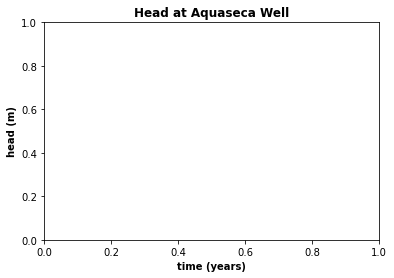

In [108]:
#Head at Aquaseca well 
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
# plt.ylim(75.2,75.8)
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(town_head_ts[j][:, 0]/360, town_head_ts[j][:, 1], label=label) #plot the time series with points at each record
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
#plt.savefig("Head_Aqua_ensem.png",dpi=600)
plt.show()


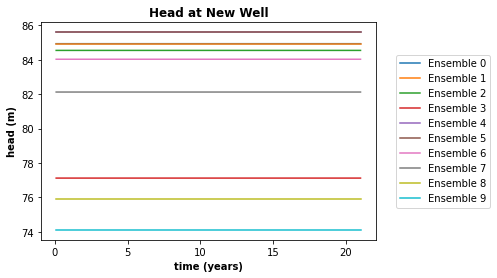

In [ ]:
# Head at observation well
plt.subplot(1, 1, 1)
plt.title("Head at New Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(mw1_head_ts[j][:, 0]/360, mw1_head_ts[j][:, 1], label=label) #plot the time series with points at each record
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
#plt.savefig("Head_M1_ensem.png",dpi=600)
plt.show()

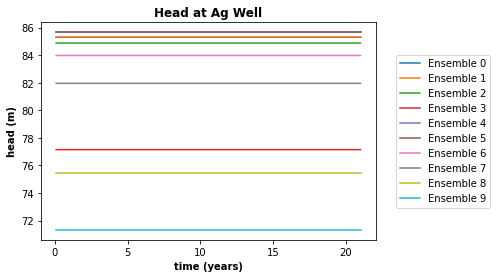

In [ ]:
#Ag Well Plot
plt.subplot(1, 1, 1)
plt.title("Head at Ag Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(ag_head_ts[j][:, 0]/360, ag_head_ts[j][:, 1], label=label) #plot the time series with points at each record

plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
#plt.savefig("Head_irri_ensem.png",dpi=600)
plt.show()

## Alternate approach: Read in variables and store as dictionaries

In [ ]:
#setup some structures to store data in 
head = np.tile({}, n_ens)
leakage = np.tile({}, n_ens)
fff = np.tile({}, n_ens)
stor = np.tile({}, n_ens)
recharge = np.tile({}, n_ens)
et = np.tile({}, n_ens)
frf = np.tile({}, n_ens)


# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   
                   
    head[i] = {}
    leakage[i] = {}
    fff[i] = {}
    stor[i] = {}
    recharge[i] = {}
    et[i] = {}
    frf[i] = {}

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')
   
    #store the complete arrays in dictionaries
    for stress_per, time in enumerate(times): #iterate through times at end of each stress period
        head[i]['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
        leakage[i]['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
        fff[i]['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
        frf[i]['sp%s'%(stress_per)] = budgobj.get_data(text='flow right face', totim=time)
        stor[i]['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        recharge[i]['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time) 
        et[i]['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time) 